# Introduction to Bagging

-----


In this notebook, we introduce the concept of [_bagging_][wbag], which is shorthand for bootstrap aggregation, where random samples of the data are used to construct multiple decision trees. Since each tree only sees part of the data, each tree is less accurate than if it had been constructed over the full data set. Thus, each tree is known as a _weak learner_. A more powerful, meta-estimator is subsequently constructed by averaging over these many weak learners. The approach of constructing weak learners, and combining them into a more powerful estimator is at the heart of several, very powerful machine learning techniques, among which, the most popular one is the [random forest][wrf].

In this notebook, we first introduce the formalism behind bagging, including a discussion of the concept of bootstrapping. Next, we move on to a discussion of the random forest algorithm, which will include its application to both classification and regression tasks.

-----
[wbag]: https://en.wikipedia.org/wiki/Bootstrap_aggregating
[wrf]: https://en.wikipedia.org/wiki/Random_forest

## Table of Contents

[Formalism](#Formalism)

- [Bootstrap](#Bootstrap)
- [Random Forest](#Random-Forest)
- [Extremely Randomized Trees](#Extremely-Randomized-Trees)

[Random Forest: Classification](#Random-Forest:-Classification)

- [Classification: Iris Data](#Classification:-Iris-Data)
- [Random Forest: Decision Surface](#Random-Forest:-Decision-Surface)
- [Random Forest: Hyperparameters](#Random-Forest:-Hyperparameters)
- [Random Forest: Feature Importance](#Random-Forest:-Feature-Importance)
- [Classification: Adult Data](#Classification:-Adult-Data)

[Random Forest: Regression](#Random-Forest:-Regression)

- [Regression: Auto MPG Data](#Auto-MPG-Data)
- [Regression: Multi-Output](#Regression:-Multi-Output)

[Extremely Randomized Trees](#Extremely-Randomized-Trees)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook
% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

One of the simplest machine learning algorithms to understand is the decision tree. Often, a decision tree is made as large as possible to provide the best predictive model, as this produces a high purity in the leaf nodes. Doing so, however, can lead to **overfitting** where the model predicts very accurately on the training data but fails to generalize to the test data; and where the accuracy is, as a result, much lower. 

A simple approach to overcoming the overfitting problem is to train many decision trees on a subset of the data and to average the resulting predictions. This process is known as bootstrap aggregation, which is often shortened to bagging. Of these two terms, aggregation is simple to understand, one simply aggregates (or, in particular, averages) the predictions of the many trees. 

The term bootstrap is a statistical term that defines how a sample can be constructed from an original data set. Given a data set, there are two simple ways to construct a new sample. As a specific example, consider building a list of shows you wish to watch from an online provider like Netflix or Amazon by placing them in  virtual cart. In the first approach, you take a show off the virtual shelf and place it in your cart, the show is no longer available on the shelf. This is known as sampling without replacement since the show is only present in your cart. In the second approach, you take a show and place it in your cart, but there remains a copy of the show on the virtual shelf and others can still pick it. This is known as sampling with replacement, since we replace the original instance.

Sampling with replacement has several advantages that make it important for machine learning. First, we can construct many large samples from our original data set, where each sample is not limited by the size of the original data set. For example, if our original data set contained 100 entries, sampling without replacement would mean we could only create ten new samples that each had ten entries. On the other hand, sampling with replacement means we could create 100 (or more) new samples that each have ten (or more) entries.

Building many samples from a parent population allows us to build an estimator on each sample and average (or aggregate) the results. This is demonstrated in the following figure, where an original data set is used to train a number of decision trees. In this case, each tree is constructed from a bootstrap sample of the original data set. The predictions from these trees are aggregated at the end to make a final prediction.

![Decision Trees Image](images/dt-rjb-2.png)

The scikit learn library provides a bagging meta-estimator, that can generate bootstrap samples, apply a standard estimator (including other algorithms beyond a decision tree), and aggregate the resulting predictions. This technique can be used for classification tasks ([`BaggingClassifier`][skbc]) or for regression ([`BaggingRegressor`][skbr])

These estimators have several hyperparameters that control their performance:
- `base_estimator`: The estimator to use on each sample, by default this is a decision tree.
- `n_estimators`: The number of base estimators to create for the ensemble, by default this is ten.
- `max_samples` : The number of instances to draw from the parent population to train each base estimator, by default this is one.
- `max_features`: The number of features to draw from the  parent population to train each base estimator, by default this is one.

This bagging estimator allows different basic algorithms, beyond the decision tree, to be used for ensemble learning. For the rest of the notebook, however, we will focus on two specific ensemble techniques that efficiently implement bagging by using decision trees: the random forest and extremely randomized trees.

Beyond improved prediction, bagging algorithms provide an additional benefit. Since each tree (or other learning algorithm in the case of a _Bagging_ estimator) is constructed from a subsample of the original data, the performance of that tree can be tested on the data from the original data that were not used in its construction. These data are known as _out-of-bag_ data, and provide a useful metric for the performance of each individual tree used in the ensemble. 

Before introducing the random forest, we first explore the construction and use of bootstrap samples.

-----
[skbc]:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
[skbr]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

[[Back to TOC]](#Table-of-Contents)

### Bootstrap

Formally, a bootstrap refers to any statistical process that relies on the generation of random samples with replacement. To demonstrate the benefit of the bootstrap, we will bootstrap the `size` feature from the _tips_ data set, which is the number of patrons served by the restaurant for a meal. We will try to estimate the population mean and variance of the `size`.

The first Code cell below loads the tips data and shows 5 samples of the `size` feature.

In the next cell, we will calculate the sample mean and variance of `size` feature based on the whole `size` column.

In the third cell, we will generate 1000 random samples with replacemen, each random sample has 50 data points. we will compute the mean for each sample, creating an array of means. In this case, we can consider each sample mean to be an estimate of the mean of the parent population. We can average these means (i.e., aggregate) these sample means to provide an estimate of the population mean, along with a measure of the uncertainty in this estimate, by computing the standard deviation of our sample means.

-----




In [2]:
# Load Data Set
tdf = sns.load_dataset('tips')

# Display several random 'size' features
tdf['size'].sample(5)

44    4
54    4
8     2
90    2
26    2
Name: size, dtype: int64

-----

The next Code cell extract `size` feature as a NumPy array, and displays the number of instances, which is 244. We also compute the mean and standard deviation of this sample. These values will be compared to the same metrics computed from the random samples we will generate.

-----

In [3]:
# Extract size feature as an array
sizes = tdf['size'].as_matrix()

# Display number of instances
print(f'Number of instances = {sizes.shape[0]}')

# Compute and display population statistics
print(f'Mean (original sample) = {np.mean(sizes):5.3f}')
print(f'Standard deviation (original sample) = {np.std(sizes):5.3f}')

Number of instances = 244
Mean (original sample) = 2.570
Standard deviation (original sample) = 0.949


-----

We can now generate 1000 random samples, with replacement from these data. In the following Code cell, we create a NumPy `RandomState` to ensure reproducibility of our results, and define our initial sample size as 50. This value can be changed, and since we are using replacement, can actually be larger than the size of the parent population (although this is generally not a good idea). Finally, we employ the NumPy `choice` method to sample `sample_size` instances with replacement, which is indicated by passing the parameter `replace=True`. 

The output is a NumPy array that is randomly sampled with replacement from the parent array, `sizes`. Note, if we pass the parameter `replace=False` we produce a sample without replacement, which can be useful in other contexts.

We then calculate the mean and standard deviation of the random sample means.

-----

In [4]:
sample_size = 50
num_samples = 1000

# Define random seed for reproducability
rng = np.random.RandomState(23)

the_sample = np.zeros((num_samples, sample_size))

#for idx in range(num_samples):
#    for j in range(sample_size):
#        the_sample[idx][j] = rng.choice(sizes, 1, replace=True)

for idx in range(num_samples):
    the_sample[idx] = rng.choice(sizes, sample_size, replace=True)

print(the_sample.shape)
# Compute and display sample statistics
the_means = np.mean(the_sample, axis=1)
print(f'Mean ({num_samples} samples) = {np.mean(the_means):5.3f}')
print(f'Standard Deviation ({num_samples} samples) = {np.std(the_means):5.3f}')


(1000, 50)
Mean (1000 samples) = 2.571
Standard Deviation (1000 samples) = 0.131


-----

The mean of the random sample means is nearly identical to the mean value of our sample mean with 244 data points, but the uncertainty(standard deviation) on this estimate is remarkably low.

This simple example has demonstrated how bootstrap aggregation, in this case of the sample means, can provide a powerful estimator of a population statistic. In each case, we generate multiple samples with replacement, and compute a statistics across these samples, and aggregate the result at the end. This concept underlies all bagging estimators.

-----

-----

[[Back to TOC]](#Table-of-Contents)

### Random Forest

Bootstrap is a general procedure that can be used to reduce the variance for those algorithm that have high variance. An algorithm that has high variance are decision trees. When bagging with decision trees, we are less concerned about individual trees overfitting the training data.

A [random forest][wrf] employs bagging to create a set of decision trees from a given data set. Each tree is constructed from a bootstrap sample, and the final prediction is generated by aggregating the predictions of the individual trees, just like the previous code example demonstrated by using the mean of the sample means to estimate the population mean.

Normally, when deciding on a split point during the construction of a decision tree, all features are evaluated and the one that has the highest impurity (or produces the largest information gain) is selected as the feature on which to split along with the value at which to split that feature. In a random forest, a random subset of all features are used to make the split choice, and the best feature on which to split is selected form this subset. 

This extra randomness produces individual decision trees that are less sensitive to small scale fluctuations, which is known as under-fitting. As a result, each newly created decision tree is a weak learner since they are not constructed from all available information. Yet, since each decision tree is constructed from different sets of features, by aggregating their predictions, the final random forest prediction is improved and less affected by overfitting.

Each tree in the random forest is constructed from a different combination of features. As a result, we can use the _out-of-bag_ performance from each tree to rank the importance of the features used to construct the trees in the forest. This allows for robust estimates of feature importance to be computed after constructing a random forest, which can provide useful insight into the nature of a training data set.

-----

[wrf]: https://en.wikipedia.org/wiki/Random_forest



[[Back to TOC]](#Table-of-Contents)

## Random Forest: Classification

Having completed the discussion on bootstrap aggregation, and introduced the random forest algorithm, we can now transition to putting this powerful ensemble algorithm to work. The scikit learn library provides a robust implementation of the random forest algorithm. This implementation includes the _Bagging estimator's_ hyperparameters. The two most important hyperparameters for a random forest are
- `n_estimators`, which is the number of decision trees that will be constructed to build the forest, the default value is ten, and 
- `max_features`, which is the number of features to examine when choosing the best split feature and value. By default this is `auto`, which means the square root of the total number of features. Other values can be an integer number of features, a floating point percentage of the total number of features (e.g., 25% of all features randomly selected), the square root of the total number of features, and the base two logarithm of the total number of features.

You may run `help(RandomForestClassifier)` to view more details about the model and the hyper parameters.

To demonstrate using a random forest with the scikit-learn library, we will use [Adult Income Dataset][uciad] to see the impact of a random forest on generating predictions from a complex data set.

----
[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult

-----

[[Back to TOC]](#Table-of-Contents)

### Classification:  Adult Income Data

We can now apply the Random Forest algorithm to the Adult Income data to create a classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Prepare data. We first load data from UCI repository, then create label from `Salary` column, then encode categorical features. Note that for tree-based ensemble classifier, we don't have to create dummy variables for categorical features, and we also don't need to scale or normalize training features. Finally, we will split the data into training and testing sets.
2. Import our estimator, [`RandomForestClassifier`][skrfc], from the proper scikit-learn module, `ensemble`.
3. Create the estimator and specify the appropriate hyperparameters. For a random forest, we can accept the defaults, or specify values for specific hyperparameters such as `n_estimators` or `max_features`.
4. Fit the model to the training data.
5. Predict new classes with our trained model (or in the simple demonstration below, generate a performance metric via the `score` method).

These steps are demonstrated in the following code cell.

In the first code cell, we load the data and create label from `Salary`. 

In the second code cell, we encode categorical features we are going to choose. We will only encode features with string values. Then we will define label and data, and split them to 60% training and 40% testing.

In the third code cell, we create the estimator, the only hyperparameter that we specify at this time is  random_state in order to ensure reproducibility. Then we fit the estimator to our training data, and generate a performance score on the testing data.

In the next code cell we plot the confusion matrix.

-----
[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [5]:
data_file = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
col_names = ['Age', 'Workclass', 'FNLWGT', 'Education', 
             'EducationLevel', 'MaritalStatus', 'Occupation', 
             'Relationship', 'Race', 'Sex', 'CapitalGain', 'CapitalLoss', 
             'HoursPerWeek', 'NativeCountry', 'Salary']

# Read CSV data from URL return Pandas
adult_data = pd.read_csv(data_file, index_col=False, names = col_names)

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

adult_data.sample(5)


,Age,Workclass,FNLWGT,Education,EducationLevel,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Salary,Label
12172,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,?,<=50K,0
7130,69,Self-emp-not-inc,128206,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,30,United-States,<=50K,0
14070,60,Private,145664,Some-college,10,Divorced,Sales,Not-in-family,White,Female,0,0,48,United-States,<=50K,0
23964,38,Self-emp-not-inc,58972,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,<=50K,0
14126,44,Private,187584,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,Canada,<=50K,0


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode categorical features with string value
adult_data['Sex_code'] = LabelEncoder().fit_transform(adult_data.Sex)
adult_data['Relationship_code'] = LabelEncoder().fit_transform(adult_data.Relationship)
adult_data['Race_code'] = LabelEncoder().fit_transform(adult_data.Race)

#pick training features
data = adult_data[['Age', 'HoursPerWeek', 'EducationLevel', 'CapitalGain', 'CapitalLoss', 'Sex_code', 'Relationship_code', 'Race_code']]
label = adult_data['Label']

#split to training and testing
d_train, d_test, l_train, l_test = train_test_split(data, label, test_size=0.4, random_state=23)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

adult_model = RandomForestClassifier(random_state=23)

adult_model = adult_model.fit(d_train, l_train)

# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Decision Tree Classification [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(metrics.classification_report(l_test, predicted)))


Decision Tree Classification [Adult Data] Score = 84.0%

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      9811
           1       0.71      0.60      0.65      3214

   micro avg       0.84      0.84      0.84     13025
   macro avg       0.79      0.76      0.77     13025
weighted avg       0.83      0.84      0.84     13025




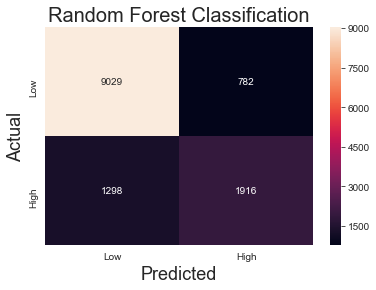

In [8]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test, predicted, ['Low', 'High'], 'Random Forest Classification')

-----

[[Back to TOC]](#Table-of-Contents)

### Random Forest:  Feature Importance

As the previous example demonstrated, the random forest is easy to use and often provides impressive results. In addition, by its very nature, a random forest provides an implicit measure of the importance of the individual features in generating the final predictions. While an individual decision tree provides this information, the random forest provides an aggregated result, that is generally more insightful and less sensitive to fluctuations in the training data that might bias the importance values determined by a decision tree. In the calculation of feature importance from a random forest, higher values indicate a more important feature. 

We demonstrate how to extract the feature importance for a random forest classifier in the following Code cell. We zip the training data column names with the model's feature_importances_ attribute, then convert it to a dataframe so that we can sort by the importance and print it out.

From the feature importance we can see that Sex and Race are not very important in determining income, comparing to Age and Education Level.

----

In [9]:
# Display feature importance as computed from the random forest

# Display name and importance
feature_importance = pd.DataFrame(list(zip(d_train.columns, adult_model.feature_importances_)), columns=['Feature', 'Importance'])
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Age,0.258865
2,EducationLevel,0.185578
6,Relationship_code,0.170906
1,HoursPerWeek,0.146041
3,CapitalGain,0.140547
4,CapitalLoss,0.053635
5,Sex_code,0.022270
7,Race_code,0.022159


### Compare with Decision Tree

Random forests consist of multiple single decision trees each based on a random sample of the training data. They are typically more accurate than single decision trees.

In the following code cell, we will apply a decision tree classifier on same data set created above and compare the performance with that of the random forest.

We can see that random forest classifier model achieves better score, performs better in both precision and recall on both classes(low and high).

Decision Tree Classification [Adult Data] Score = 82.0%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      9811
           1       0.66      0.56      0.61      3214

   micro avg       0.82      0.82      0.82     13025
   macro avg       0.76      0.73      0.74     13025
weighted avg       0.81      0.82      0.82     13025




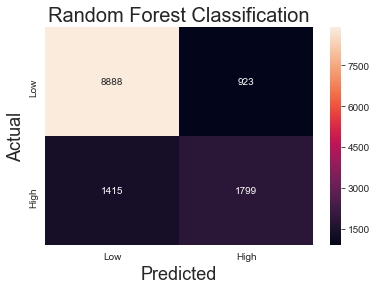

In [10]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=23)

dtc = dtc.fit(d_train, l_train)
# Classify test data and display score and report
predicted = dtc.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Decision Tree Classification [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(metrics.classification_report(l_test, predicted)))
ml.confusion(l_test, predicted, ['Low', 'High'], 'Random Forest Classification')

-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cell, we create random forest classifier with default hyperparamemter values. Try making the following changes and compare the different results.

1. Set the values of hyperparameter `n_estimators` to 5, 10 and 15.
2. Set pyperparameter `max_features` to different values to indicate how many features should be used in the splitting process.
-----


[[Back to TOC]](#Table-of-Contents)

## Random Forrest: Regression

A random forest can also be used to perform regression; however, in this case the goal is  to create tress whose leaf nodes contain data that are nearby in the overall feature space. To make a predict a continuous value from a tree we either have leaf nodes with only one feature, and use the relevant feature from that instance as our predictor, or we compute summary statistics from the instances in the appropriate leaf node, such as the mean or mode. In the end, the random forest aggregates the indivudla tree regreession predictions into a final prediction.

To perform regression with the scikit-learn library we employ the [`RandomForestRegressor`][skrfr] estimator in the tree module. This estimator employs the same set of hyperparameters as the `RandomForestClassifier` estimator, and is, therefore, used in a similar manner. One point, which was also true for classification, by specifying the `random_state` hyperparameter, we ensure reproducibility. This is because every time a tree is constructed, the features are randomly selected. Thus, even if we use the same set of hyperparameters and the same set of training data, we can end up with different trees, and thus a different forest, if the `random_state` hyperparameter is not fixed.

In this section we employ a random forest to perform regression on the automotive fuel performance prediction, these data were fully described in the _Introduction to Decision Trees_ notebook. First, we will introduce these data, and prepare them for the regression task. We will employ the patsy module to use a regression formula to create our dependent and independent feature matrices. Finally, we will construct a decision tree regressor on these data and evaluate its performance.


-----

[skrfr]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

-----

[[Back to TOC]](#Table-of-Contents)

### Regression: Auto MPG Data

Random forest can also be used to perform regression. To perform regression with the scikit-learn library we employ the RandomForestRegressor estimator in the ensemble module. This estimator employs the same set of hyperparameters as the RandomForestClassifier estimator, and is, therefore, used in a similar manner. One other point, which is also true for classification, by specifying the random_state hyperparameter, we ensure reproducibility.

In this section we employ decision trees to perform regression on the [automobile fuel performance prediction data][uciap]. The data contains nine features: mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin, and car name. Of these, the first is generally treated as the dependent variable (i.e., we wish to predict the fuel efficiency of the cars), while the next seven features are generally used as the independent variables. The last feature(car name) is a string that unlikely to be useful when predicting on new, unseen data; and is, therefore, not included in our analysis.

Of these features, three are discrete: cylinders, year, and origin; and four are continuous: displacement, horsepower, weight, and acceleration. A careful examination of these data indicate that horsepower has missing values, encoded as the string `?`. This causes Pandas to treat this entire column as a string, and the patsy module will, therefore, turn the column into a categorical feature. As a result, we will drop this column in our subsequent analysis; an alternative would be to drop or impute the missing values and include this column as a numerical feature.

In the first two Code cells, we first load the data into a DataFrame, using our provided column names and indicating that the features are delimited by whitespace. After this, we select our independent and dependent variables. 

----
[uciap]: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [11]:
data_file = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
# Names for our columns
col_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Year', 'Origin', 'Name']

# Create DataFrame and sample the result
auto_data = pd.read_csv(data_file, index_col=False, names = col_names, 
                  delim_whitespace=True)
auto_data.sample(5, random_state=2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin,Name
94,13.0,8,440.0,215.0,4735.0,11.0,73,1,chrysler new yorker brougham
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
279,29.5,4,98.0,68.00,2135.0,16.6,78,3,honda accord lx
178,23.0,4,120.0,88.00,2957.0,17.0,75,2,peugeot 504
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i


In [12]:
y = auto_data['MPG']
x = auto_data[['Cylinders', 'Displacement', 'Weight', 'Acceleration', 'Year', 'Origin']]

-----

With the dependent variable(y) and independent variable(x) determined, we can now build a regressive model. First, we import the `RandomForestRegressor` before splitting our independent and dependent variables into training and testing samples. Next, we create our estimator, specifying a value for our `random_state` hyperparameter to enable reproducibility. Finally, we fit the model and display a predictive score. 

The second Code cell computes a number of different regression performance metrics and displays the results. 

This model predicts the fuel performance pretty well. You may compare the regression performance metrics with that of other machine learning algorithms we introduced in previous lessons.

-----

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Split data intro training:testing data set
ind_train, ind_test, dep_train, dep_test = train_test_split(x, y, test_size=0.4, random_state=23)

# Create Regressor with default properties
auto_model = RandomForestRegressor(random_state=23)

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
print('Score = {:.1%}'.format(auto_model.score(ind_test, dep_test)))

Score = 84.7%


In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Regress on test data
pred = auto_model.predict(ind_test)

# Copute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

# Display metrics
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')


R^2 Score             = 0.847
Mean Absolute Error   = 2.16
Mean Squared Error    = 8.27


-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a random forest for regression and applied it to the automobile fuel performance prediction task. The initial result was pretty good, but try making the following changes to see if you can do better.

1. Change the features used in the regression, for example drop one column, such as `origin`. Do the results change? 
2. Try using different hyperparameter values, such as changing the number of estimators (`n_estimators`) or the number of features (`max_features`).

-----

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. The scikit learn documentation provides a nice introduction to [_bagging_][1] and the estimators that implement this ensemble learning technique.
1. A blog [article][2] on random forests in Python
2. An article on [building random forests][3] from scratch in Python at the Machine Learning Mastery website
2. An article on [random forests][3] at the Analytics Vidhya website
3. A short [discussion][5] on the benefits of random forests
4. A long [discussion][6] on random forests
-----
[1]: http://scikit-learn.org/stable/modules/ensemble.html#bagging

[2]: http://blog.yhat.com/posts/random-forests-in-python.html

[3]: https://machinelearningmastery.com/implement-random-forest-scratch-python/

[4]: https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/

[5]: http://fastml.com/intro-to-random-forests/

[6]: http://www.cip-labs.net/2013/01/17/introduction-to-random-forests/